# Dog Breed Classification

This project creates a machine learning model which is designed to classify images into one of 133 different dog breeds, using the comprehensive dog breed dataset provided by Udacity (https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip). The model utilizes the pre-trained ResNet-50 architecture, a deep learning model known for its excellent performance in image recognition tasks (https://download.pytorch.org/models/resnet50-19c8e357.pth).

To adapt ResNet-50 for dog breed classification, the original classification layer of the model was replaced with a new fully connected layer specifically designed for 133 output classes. This new layer was then fine-tuned using the provided dog breed dataset. By leveraging transfer learning, the model retains the powerful feature extraction capabilities of ResNet-50 while focusing on the specific task of classifying different dog breeds. This approach combines the strengths of pre-trained deep learning models with the customization required for the unique dog breed classification challenge.

In [10]:
import os
import logging

import boto3
import sagemaker
from sagemaker.s3 import S3Downloader
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch

## Dataset

The dataset used for this project is a dog breed dataset provided by Udacity, which consists of images from 133 different dog breeds. The dataset is divided into three parts: training, testing, and validation sets.

Training Set: The training set contains approximately 60 images per dog breed. This large collection of images helps the model learn diverse features of each breed.
Test Set: The test set consists of 6 to 8 images per breed, which are used to evaluate the model’s generalization capability after training.
Validation Set: Similar to the test set, the validation set includes 6 to 8 images per breed.

The images in the dataset feature dogs in various poses and with a variety of coat colors, helping the model learn to recognize breeds from different angles and appearances. This diversity is important for ensuring the model can generalize well across real-world images of dogs, which may vary greatly in lighting, background, and posture.

In [ ]:
def download_dog_data_from_s3():
    """
    Lädt Daten von S3 herunter und speichert sie lokal.
    """
    train_local_path = os.path.join("./dogImages", "train")
    valid_local_path = os.path.join("./dogImages", "valid")
    test_local_path = os.path.join("./dogImages", "test")
    try:
        if not os.path.exists(train_local_path):
            os.makedirs(train_local_path)
            print("Downloading train data from s3://project-bucket-fj/dogImages/train/")
            S3Downloader.download("s3://project-bucket-fj/dogImages/train/", train_local_path)
        else:
            print(f"Train data already exists at {train_local_path}")
        if not os.path.exists(valid_local_path):
            os.makedirs(valid_local_path)
            print("Downloading valid data from s3://project-bucket-fj/dogImages/valid/")
            S3Downloader.download("s3://project-bucket-fj/dogImages/valid/", valid_local_path)
        else:
            print(f"Test data already exists at {test_local_path}")
        if not os.path.exists(test_local_path):
            os.makedirs(test_local_path)
            print("Downloading test data from s3://project-bucket-fj/dogImages/test/")
            S3Downloader.download("s3://project-bucket-fj/dogImages/test/", test_local_path)
        else:
            print(f"Test data already exists at {test_local_path}")
    except Exception as e:
        print(f"Error downloading data: {e}")
        raise


#download_dog_data_from_s3()

In [ ]:
s3 = boto3.client('s3')

bucket_name = 'project-bucket-fj'
local_data_path = 'dogImages'

for root, dirs, files in os.walk(local_data_path):
    for filename in files:
        if filename.endswith('.jpg') or filename.endswith('.png'):
            local_file_path = os.path.join(root, filename)
            relative_path = os.path.relpath(local_file_path, local_data_path)
            s3.upload_file(local_file_path, bucket_name, f'training_data/{relative_path}')
            print(f'Uploaded {filename} to {bucket_name}/training_data/{relative_path}')

In [ ]:
# Not needed

# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages.zip

## Hyperparameter Tuning

The learning rate (lr) was selected to range from 0.001 to 0.01. They are small enough to allow stable convergence while still being large enough to make relatively fast progress. The automatic scaling ensures that the hyperparameter tuning process is more efficient and flexible.

For the batch size (batch_size), values of 16, 32, and 64 were chosen. Smaller batch sizes, like 16, result in more frequent updates to the model's weights, which can be beneficial for smaller datasets or memory-intensive models. Larger batch sizes, such as 64, tend to result in more stable gradient calculations but require more memory, which is important for larger models or datasets.

The number of epochs (epochs) was set between 2 and 4, as a smaller number of epochs is useful in early experiments to quickly evaluate the model and avoid overfitting. The number of epochs was limited to a maximum of 4 to ensure that the training does not take too long. This is particularly important when fast results are needed or when resources are limited. With just a few epochs, the model is able to learn basic patterns without overfitting, as it does not spend too much time on the training data. This allows for efficient use of computational resources and quick evaluation of model performance, while avoiding unnecessary prolonged training.

In [2]:
sagemaker_session = sagemaker.Session()

bucket = "s3://project-bucket-fj/"
prefix = "sagemaker/dogClasses"

role = sagemaker.get_execution_role()

In [3]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.01, scaling_type="Auto"),
    "batch_size": CategoricalParameter([16, 32, 64]),
    "epochs": IntegerParameter(2, 4)
}

In [5]:
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large",
    output_path="s3://project-bucket-fj/models/"
)

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=6,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [11]:
input_channels = {
    "train": "s3://project-bucket-fj/dogImages/train/",
    "test": "s3://project-bucket-fj/dogImages/test/",
    "data": "s3://project-bucket-fj/dogImages/"
}

In [ ]:
tuner.fit(input_channels)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [8]:
best_estimator = tuner.best_estimator()

print("BEST HYPERPARAMETERS:")
print(best_estimator.hyperparameters())


2025-01-15 10:02:20 Starting - Found matching resource for reuse
2025-01-15 10:02:20 Downloading - Downloading the training image
2025-01-15 10:02:20 Training - Training image download completed. Training in progress.
2025-01-15 10:02:20 Uploading - Uploading generated training model
2025-01-15 10:02:20 Completed - Resource reused by training job: pytorch-training-250115-0715-006-c9c8347c
BEST HYPERPARAMETERS:
{'_tuning_objective_metric': '"average test loss"', 'batch_size': '"64"', 'epochs': '4', 'lr': '0.006597651956372749', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2025-01-15-07-15-57-474"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://project-bucket-fj/pytorch-training-2025-01-15-07-15-57-474/source/sourcedir.tar.gz"'}


In [10]:
analytics = tuner.analytics()
tuning_results = analytics.dataframe()

tuning_results

,batch_size,epochs,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""64""",4.0,0.006467,pytorch-training-250115-0715-006-c9c8347c,Completed,0.0188,2025-01-15 10:02:22+00:00,2025-01-15 11:55:47+00:00,6805.0
1,"""16""",3.0,0.003225,pytorch-training-250115-0715-005-63133cb9,Completed,0.0208,2025-01-15 09:47:28+00:00,2025-01-15 10:55:11+00:00,4063.0
2,"""64""",4.0,0.006598,pytorch-training-250115-0715-004-c7cfb62d,Completed,0.0175,2025-01-15 08:06:52+00:00,2025-01-15 09:59:49+00:00,6777.0
3,"""32""",4.0,0.006221,pytorch-training-250115-0715-003-7a8ef292,Completed,0.0194,2025-01-15 08:06:49+00:00,2025-01-15 09:46:19+00:00,5970.0
4,"""16""",2.0,0.007482,pytorch-training-250115-0715-002-4da285b7,Completed,0.0217,2025-01-15 07:17:11+00:00,2025-01-15 08:06:05+00:00,2934.0
5,"""16""",2.0,0.007135,pytorch-training-250115-0715-001-6176dd08,Completed,0.0260,2025-01-15 07:16:54+00:00,2025-01-15 08:05:03+00:00,2889.0


## Model Profiling and Debugging

In [2]:
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp311-cp311-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [8]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
import IPython
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

In [4]:
hyperparameters = {
    "lr": 0.006597651956372749,
    "batch_size": 64,
    "epochs": 4
}

input_channels = {
    "train": "s3://project-bucket-fj/dogImages/train/",
    "valid": "s3://project-bucket-fj/dogImages/valid/",
    "test": "s3://project-bucket-fj/dogImages/test/",
    "data": "s3://project-bucket-fj/dogImages/"
}

In [5]:
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

In [6]:
collection_configs = [CollectionConfig(name="CrossEntropyLoss_output_0", parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10", "eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config = DebuggerHookConfig(
    collection_configs=collection_configs
)

metric_definitions = [{"Name": "Train Loss", "Regex": "Train Loss: ([0-9\\.]+)"},{"Name": "Test Loss", "Regex": "Average Test Loss: ([0-9\\.]+)"}]

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [11]:
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
    metric_definitions=metric_definitions
)

In [34]:
estimator.fit(input_channels, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2025-01-17-12-20-11-671


2025-01-17 12:20:16 Starting - Starting the training job...
2025-01-17 12:20:41 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2025-01-17 12:21:08 Downloading - Downloading input data...............
2025-01-17 12:23:42 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-01-17 12:23:35,188 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-01-17 12:23:35,191 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-01-17 12:23:35,200 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-01-17 12:23:35,204 sagemaker_pytorch_container.training INF

In [35]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [17]:
#description

In [36]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2025-01-17 14:22:08.053 default:125 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-818551132000/pytorch-training-2025-01-17-12-20-11-671/debug-output
[2025-01-17 14:22:08.465 default:125 WARNING s3handler.py:184] Encountered the exception [SYS] unknown error (_ssl.c:2580) while reading s3://sagemaker-us-east-1-818551132000/pytorch-training-2025-01-17-12-20-11-671/debug-output/index/000000000/000000000100_worker_0.json . Will retry now


In [37]:
trial.tensor_names()

[2025-01-17 14:22:14.706 default:125 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-01-17 14:22:15.722 default:125 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1',
 '

In [38]:
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))
print(trial.tensor("CrossEntropyLoss_output_0"))

42
108


In [39]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


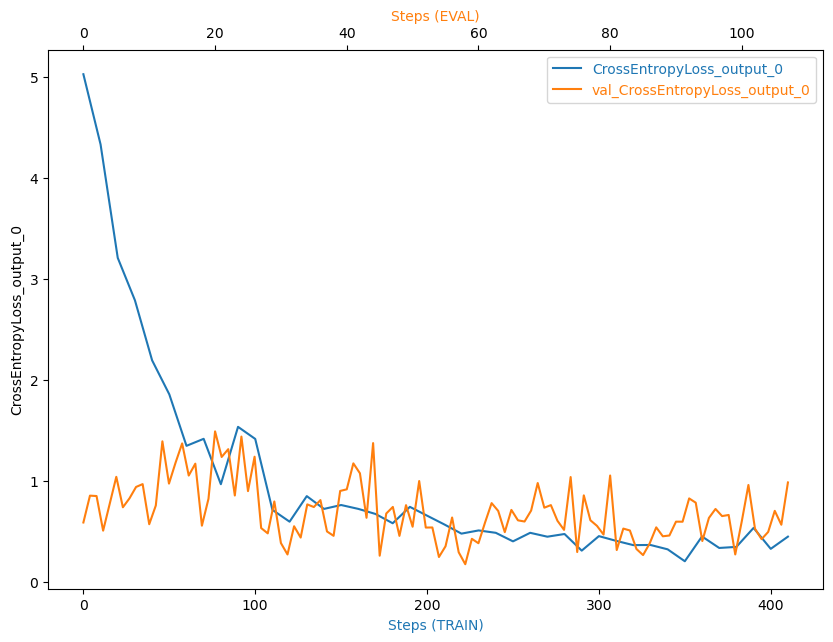

In [40]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

During training, the CrossEntropyLoss_output_0 metric does not appear to improve significantly after a certain point, which may indicate the onset of overfitting. This is further evidenced by the fluctuating values of CrossEntropyLoss_output_0 during evaluation. To mitigate this, it would be prudent to save only the model that achieves the lowest loss value both during training and evaluation. This approach ensures that the best-performing model, which generalizes well to unseen data, is selected and prevents overfitting.

In [41]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2025-01-17-12-20-11-671
Region: us-east-1


In [42]:
pip install --upgrade bokeh==2.4.3

Note: you may need to restart the kernel to use updated packages.


In [43]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-818551132000/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-818551132000/pytorch-training-2025-01-17-12-20-11-671/profiler-output


Profiler data from system is available


In [44]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2025-01-17 14:23:26.063 default:125 INFO metrics_reader_base.py:134] Getting 121 event files
[2025-01-17 14:23:26.253 default:125 WARNING s3handler.py:184] Encountered the exception [SSL] record layer failure (_ssl.c:2580) while reading s3://sagemaker-us-east-1-818551132000/pytorch-training-2025-01-17-12-20-11-671/profiler-output/system/incremental/2025011712/1737116400.algo-1.json . Will retry now
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


In [45]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-818551132000/pytorch-training-2025-01-17-12-20-11-671/rule-output


In [46]:
! aws s3 ls {rule_output_path} --recursive

2025-01-17 14:20:33     375105 pytorch-training-2025-01-17-12-20-11-671/rule-output/ProfilerReport/profiler-output/profiler-report.html
2025-01-17 14:20:32     223019 pytorch-training-2025-01-17-12-20-11-671/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2025-01-17 14:20:27        193 pytorch-training-2025-01-17-12-20-11-671/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2025-01-17 14:20:27        201 pytorch-training-2025-01-17-12-20-11-671/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2025-01-17 14:20:27       1821 pytorch-training-2025-01-17-12-20-11-671/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2025-01-17 14:20:27        127 pytorch-training-2025-01-17-12-20-11-671/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2025-01-17 14:20:27        200 pytorch-training-2025-01-17-12-20-11-671/rule-output/ProfilerReport/profiler-output/profiler-re

In [47]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-818551132000/pytorch-training-2025-01-17-12-20-11-671/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-818551132000/pytorch-training-2025-01-17-12-20-11-671/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-818551132000/pytorch-training-2025-01-17-12-20-11-671/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-818551132000/pytorch-training-2025-01-17-12-20-11-671/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-818551132000/pytorc

In [48]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [50]:
print(estimator.model_data)

s3://sagemaker-us-east-1-818551132000/pytorch-training-2025-01-17-12-20-11-671/output/model.tar.gz


## Model Deploying

Had to load my model from S3, because i continued this project on another day.

In [51]:
import json
import torch
import sagemaker
from PIL import Image
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
import io

In [52]:
role = get_execution_role()
model_s3_path = "s3://sagemaker-us-east-1-818551132000/pytorch-training-2025-01-17-12-20-11-671/output/model.tar.gz"

In [53]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [54]:
pytorch_model = PyTorchModel(model_data=model_s3_path,
                             role=role,
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')

----------!

In [55]:
image_path = "dogImages/valid/081.Greyhound/Greyhound_05528.jpg"

In [56]:
with open(image_path, "rb") as f:
    payload = f.read()

response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
print(response)

{'predicted_class': 81}


# Class 81 is Greyhound.

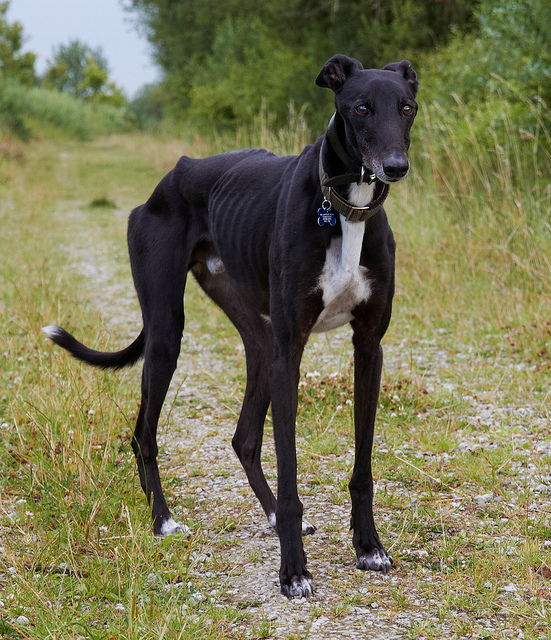

In [57]:
Image.open(io.BytesIO(payload))

In [50]:
predictor.delete_endpoint()